# Import libraries
import libraries ที่จำเป็นในการ train/test/validate deep learning model 

In [1]:
import numpy as np
import torch
from torch import nn, optim
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from tqdm.auto import tqdm

# Data preparation
เตรียมข้อมูล spiral dataset 

รูปทรงของข้อมูลเป็น 2D points ที่มี label เป็น 0 หรือ 1 
(archimedean spiral dataset ที่มี 2 spirals ที่แยกจากกัน อันนึงหมุนขวา อีกอันนึงหมุนซ้าย)

## ตัวอย่างข้อมูล


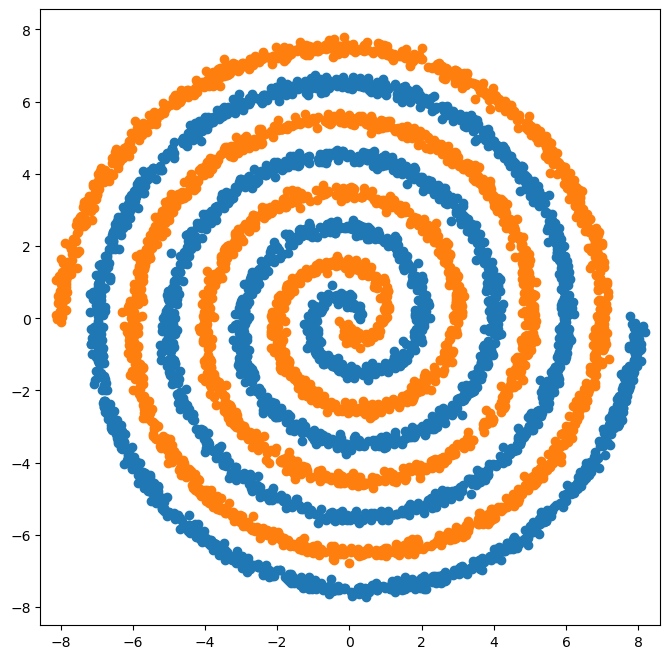

In [2]:
R = 8       # Spiral radius
N = 3000    # Data points

positive_r = np.random.triangular(0, R, R, N)
negative_r = np.random.triangular(0, R, R, N)

positive_x = positive_r * np.cos(positive_r * np.pi) + np.random.normal(0, 0.1, len(positive_r))
positive_y = positive_r * np.sin(positive_r * np.pi) + np.random.normal(0, 0.1, len(positive_r))
negative_x = -negative_r * np.cos(negative_r * np.pi) + np.random.normal(0, 0.1, len(negative_r))
negative_y = -negative_r * np.sin(negative_r * np.pi) + np.random.normal(0, 0.1, len(negative_r))

positive_label = np.ones_like(positive_x)
negative_label = np.zeros_like(negative_x)

positive_pos = np.stack((positive_x, positive_y), axis=1)
negative_pos = np.stack((negative_x, negative_y), axis=1)

spiral_X = np.concatenate((positive_pos, negative_pos), axis=0)
spiral_Y = np.concatenate((positive_label, negative_label), axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(positive_pos[:, 0], positive_pos[:, 1])
plt.scatter(negative_pos[:, 0], negative_pos[:, 1])
plt.axis('equal')
plt.show()

## Split train/test/validate
อย่างแรกคือแบ่งข้อมูล test ออกมา 20% ของข้อมูลทั้งหมด <br>
จากนั้นส่วนที่เหลือจะถูกแบ่งเป็น train และ validation โดย train จะมี 70% ของข้อมูลที่เหลือ และ validation จะมี 30% ของข้อมูลที่เหลือ

ส่วน `stratify` จะใช้เพื่อให้แน่ใจว่า label ของข้อมูล train/test/validate มีการกระจายที่เหมือนกัน <b>
(เช่น ถ้า label 0 มี 70% ของข้อมูลทั้งหมด label 1 มี 30% ของข้อมูลทั้งหมด train/test/validate ก็จะมีการกระจายที่เหมือนกัน)

In [3]:
train_and_val_X, test_X, train_and_val_Y, test_Y = train_test_split(spiral_X, spiral_Y, test_size=0.2, random_state=42, stratify=spiral_Y) 
train_X, val_X, train_Y, val_Y                   = train_test_split(train_and_val_X, train_and_val_Y, test_size=0.3, random_state=42, stratify=train_and_val_Y)

# PyTorch Dataset and DataLoader

## Dataset
PyTorch ต้องการ Dataset class ที่จะต้อง เขียน method(function) ต่างๆ 
1. `__init__`  
   - ใช้เพื่อกำหนดค่าเริ่มต้นของ dataset 
   - รับค่าเป็นข้อมูลที่ต้องการจะเก็บไว้ใช้ เช่น ข้อมูล features($X$) และ labels($y$)

2. `__len__`  
   - ใช้เพื่อบอกจำนวนข้อมูลใน dataset 
   - ต้อง return ค่าเป็นจำนวนเต็ม (integer)
3. `__getitem__`
    - ใช้เพื่อดึงข้อมูลจาก dataset 
    - รับค่าเป็น index ของข้อมูลที่ต้องการดึง 

In [4]:
class SpiralDataset(Dataset):
    def __init__(self, spiral_X, spiral_Y):
        self.x = torch.tensor(spiral_X, dtype=torch.float32)
        self.y = torch.tensor(spiral_Y, dtype=torch.float32)
    def __len__(self):
        return len(self.x)      # หรือ len(self.y) 
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] # คืนค่าคู่ (x, y) ที่ตำแหน่ง idx

### สร้าง SpiralDataset จากข้อมูล spiral dataset ที่โดนแบ่งเป็น training set, validation set และ test set ในตอนแรก

In [5]:
train_dataset = SpiralDataset(train_X, train_Y)
val_dataset = SpiralDataset(val_X, val_Y)
test_dataset = SpiralDataset(test_X, test_Y)

## DataLoader
PyTorch DataLoader ใช้สำหรับจัดการการโหลดข้อมูลจาก Dataset class ที่เราได้สร้างขึ้นมาแบบ mini-batch โดยสามารถกำหนด <br>
 - `batch_size` (จำนวนข้อมูลที่จะโหลดในแต่ละรอบ)  <br>
 - (`shuffle` คือ การสลับข้อมูลก่อนโหลด)
ในตัวอย่างคือ `batch_size=64` ใน train และ validation set และ `batch_size=1` ใน test set <br>
(หมายความว่าในตอน train และ validate จะคำนวณคำตอบครั้งละ 64 ข้อมูล แต่ตอน test จะคำนวณทีละ 1 ข้อมูล)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model
เขียนนิยามโมเดล Deep Learning ด้วย PyTorch โดยใช้ `nn.Module` ซึ่งเป็น class หลักสำหรับสร้างโมเดลใน PyTorch <br>

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"     # ใช้ GPU (Nvidia) ถ้ามี ไม่งั้นใช้ CPU ในการคำนวณ

In [8]:
class LinearAndReLU(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinearAndReLU, self).__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.linear(x))

class SimpleRegressor(nn.Module):
    def __init__(self, hidden_dims):
        super(SimpleRegressor, self).__init__()
        assert hidden_dims[0] == 2 and hidden_dims[-1] == 1, "Input dimension must be 2 and output dimension must be 1 for Binary Classification"
        hidden_dims = np.array(hidden_dims, dtype=int)
        linear_dims = np.stack((hidden_dims[:-1], hidden_dims[1:])).T
        self.model = nn.Sequential(
            *[
                LinearAndReLU(in_dim, out_dim) for in_dim, out_dim in linear_dims[:-1]
            ],
            nn.Linear(linear_dims[-1, 0], linear_dims[-1, 1]), 
        )

    def forward(self, x):
        return self.model(x)

# Training

## Training configuration

ปรับค่าใน list `arch` เพื่อกำหนดรูปร่างของโมเดล <br>
ตัวอย่างเช่น 
```python
arch = [2, 12, 16, 4, 1]
```
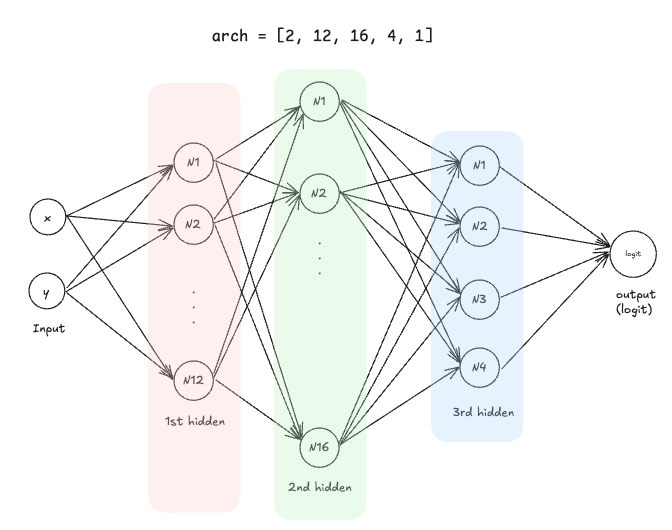

In [9]:
arch = [2, 32, 64, 32, 1] 
model = SimpleRegressor(arch).to(device) # ย้ายโมเดลไปยังอุปกรณ์ที่เลือก (GPU หรือ CPU)

epoch = 300   # จำนวนรอบการฝึก
learning_rate = 0.001 

optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Optimizer Adam ใช้ในการปรับค่าพารามิเตอร์ของโมเดล
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1) # ปรับ learning rate ทุก 200 epochs ลง 10 เท่า

criterion = nn.BCEWithLogitsLoss() # Loss function สำหรับ Binary Classification

In [10]:
summary(model, input_size=(64, 2), col_names=["input_size", "output_size", "num_params", "trainable"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleRegressor                          [64, 2]                   [64, 1]                   --                        True
├─Sequential: 1-1                        [64, 2]                   [64, 1]                   --                        True
│    └─LinearAndReLU: 2-1                [64, 2]                   [64, 32]                  --                        True
│    │    └─Linear: 3-1                  [64, 2]                   [64, 32]                  96                        True
│    │    └─ReLU: 3-2                    [64, 32]                  [64, 32]                  --                        --
│    └─LinearAndReLU: 2-2                [64, 32]                  [64, 64]                  --                        True
│    │    └─Linear: 3-3                  [64, 32]                  [64, 64]                  2,112                     True
│    

## Define training and validation function
ในแต่ละ epoch (เห็น data ทั้งหมด 1 ครั้ง) จะทำการ train และ validate โมเดล โดยจะมีการคำนวณ loss ด้วย <br>

In [11]:
avg_train_loss, avg_val_loss = [], []

def train(model, train_loader, optimizer, lr_scheduler, criterion, device):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    lr_scheduler.step()  # Update learning rate after each epoch
    return total_loss / len(train_loader)

@torch.no_grad()
def validate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        output = model(x).squeeze()
        total_loss += criterion(output, y).item()
    return total_loss / len(data_loader)

## Training loop

In [12]:
avg_train_loss, avg_val_loss = [], []
for i in (pbar := tqdm(range(epoch))): # For loop with progress bar
    train_loss = train(model, train_loader, optimizer, lr_scheduler, criterion, device) 
    val_loss   = validate(model, val_loader, criterion)

    avg_train_loss.append(train_loss)
    avg_val_loss.append(val_loss)
    
    pbar.set_description(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}") # Update progress bar description with current loss and learning rate

  0%|          | 0/300 [00:00<?, ?it/s]

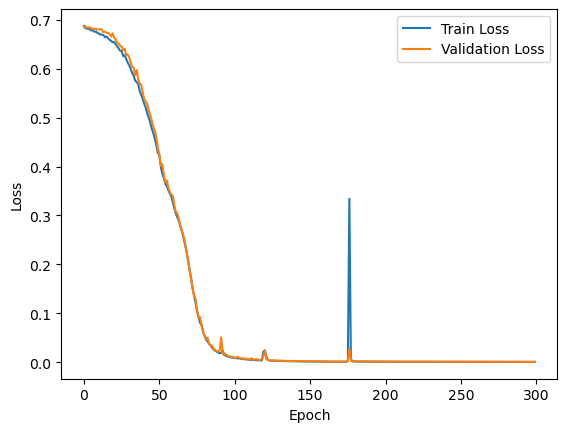

In [13]:
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing your model

In [14]:
pos_arr = [[[], []], [[], []]]
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        output = model(x).squeeze()
        pred = torch.sigmoid(output) > 0.5
        pos_arr[int(y.item())][int(pred.item())].append(x[0].tolist())

## Class segmentation

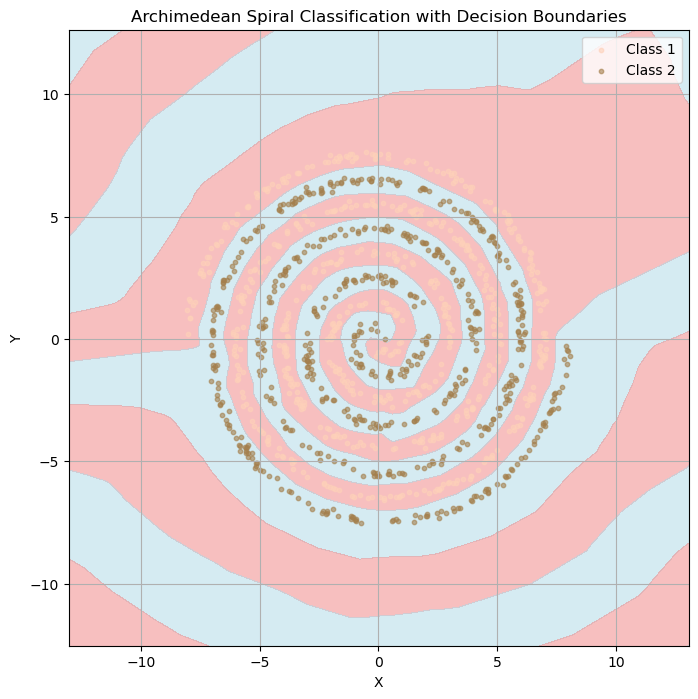

In [15]:
def plot_spirals_with_boundaries(X, y, model):
    model.eval()
    
    # Create a grid of points to evaluate the decision boundary
    x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.FloatTensor(grid)
    
    # Get model predictions for the grid
    with torch.no_grad():
        preds = model(grid_tensor).numpy().reshape(xx.shape)
    
    plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, preds, colors=['lightblue', 'lightcoral'], alpha=0.5)


    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color=[0.996, 0.82, 0.727], label='Class 1', alpha=0.6, s=10)
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color=[0.643, 0.498, 0.298], label='Class 2', alpha=0.6, s=10)
    plt.title('Archimedean Spiral Classification with Decision Boundaries')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_spirals_with_boundaries(test_X, test_Y, model)

## Plot results on test set

Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


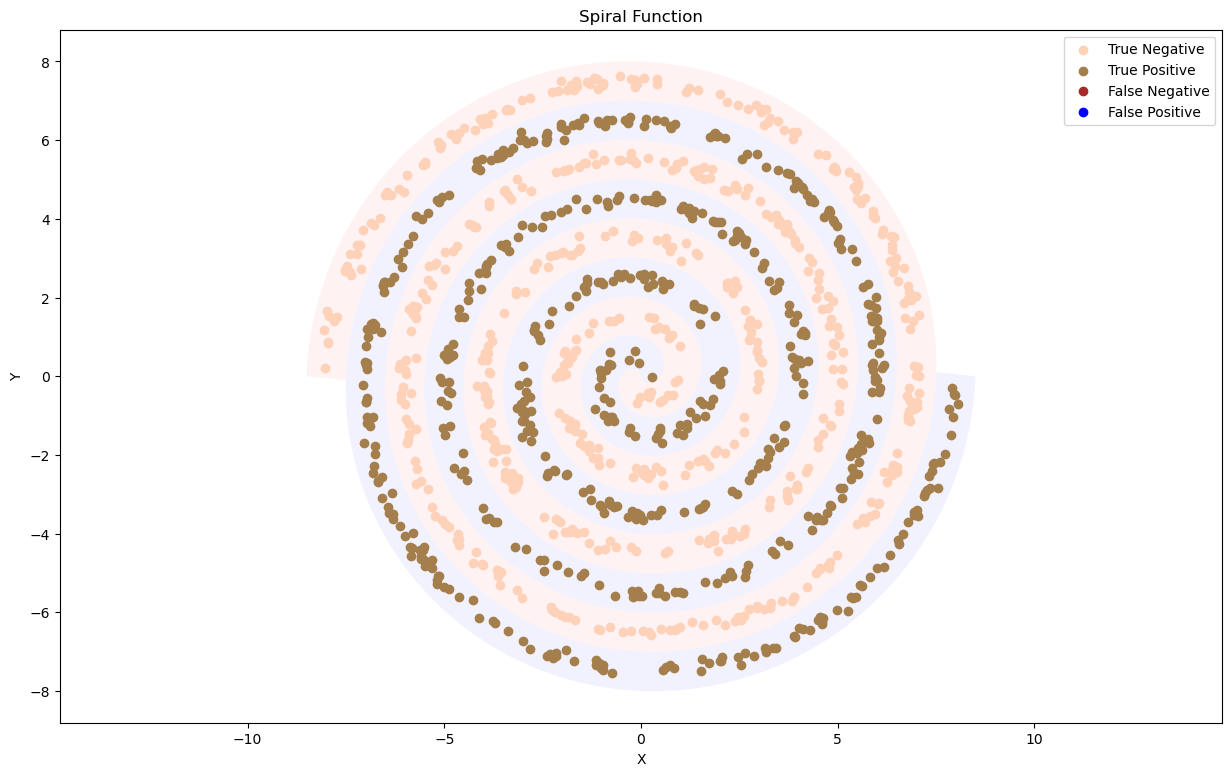

In [16]:
[tn_p, fp_p], [fn_p, tp_p] = pos_arr
tn_p, fp_p, fn_p, tp_p = np.array(tn_p), np.array(fp_p), np.array(fn_p), np.array(tp_p)
tn, fp, fn, tp = len(tn_p), len(fp_p), len(fn_p), len(tp_p)
fp_p = fp_p.reshape(-1, 2)
fn_p = fn_p.reshape(-1, 2)
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}, Precision: {tp / (tp + fp):.4f}, Recall: {tp / (tp + fn):.4f}, F1 Score: {2 * tp / (2 * tp + fp + fn):.4f}")

NN = 1000
r = np.linspace(0, R + 0.5, NN)
x1 = r * np.sin(r * np.pi)
y1 = - r * np.cos(r * np.pi)

x2 = - r * np.sin(r * np.pi)
y2 = r * np.cos(r * np.pi)

plt.figure(figsize=(15, 9))
plt.title('Spiral Function')
poly_1_x = np.concatenate((x1, x2[int(NN*(R-0.5)//(R+0.5))::-1]))
poly_1_y = np.concatenate((y1, y2[int(NN*(R-0.5)//(R+0.5))::-1]))
plt.fill(poly_1_x, poly_1_y, color='blue', alpha=0.05, edgecolor='none')

poly_2_x = np.concatenate((x2, x1[int(NN*(R-0.5)//(R+0.5))::-1]))
poly_2_y = np.concatenate((y2, y1[int(NN*(R-0.5)//(R+0.5))::-1]))
plt.fill(poly_2_x, poly_2_y, color='red', alpha=0.05, edgecolor='none')

plt.scatter(tn_p[:, 0], tn_p[:, 1], color=[0.996, 0.82, 0.727], label='True Negative')
plt.scatter(tp_p[:, 0], tp_p[:, 1], color=[0.643, 0.498, 0.298], label='True Positive')
plt.scatter(fn_p[:, 0], fn_p[:, 1], color='brown', label='False Negative')
plt.scatter(fp_p[:, 0], fp_p[:, 1], color='blue', label='False Positive')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.axis('equal')
plt.show()